## Setup

In [ ]:
!wget https://github.com/blueprints-for-text-analytics-python/blueprints-text/raw/master/data/un-general-debates/un-general-debates-blueprint.csv.gz &> /dev/null
!gunzip /content/un-general-debates-blueprint.csv.gz &> /dev/null
!pip install textacy &> /dev/null


In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import regex as re

import seaborn as sns
sns.set_style("darkgrid")

from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

import matplotlib
from matplotlib import pyplot as plt
plot_params = {'figure.figsize': (8, 4), 
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Dataset Exploration

### Load data

In [ ]:
DATA_PATH = "un-general-debates-blueprint.csv"
df = pd.read_csv(DATA_PATH)
df["text_length"] = df["text"].str.len()
df.sample(2)

,session,year,country,country_name,speaker,position,text,text_length
1748,38,1983,HUN,Hungary,LOSONCZI,NaN,"﻿26.\t Let me first offer you, Sir, a warm wel...",20452
6492,65,2010,QAT,Qatar,Sheikh Hamad bin Khalifa Al-Thani,Head of State,When I \nstood on this platform in September l...,8626


### Statistical summary

In [ ]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
 7   text_length   7507 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 232.1 MB


In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
session,7507.0,49.610763,12.892155,25.0,39.0,51.0,61.0,70.0
year,7507.0,1994.610763,12.892155,1970.0,1984.0,1996.0,2006.0,2015.0
text_length,7507.0,17967.281604,7860.038463,2362.0,12077.0,16424.0,22479.5,72041.0


- Mean
and standard deviation do not make much sense for `year` and `session`, but minimum and maximum are still interesting. 
- Our dataset contains speeches from the 25th to the 70th UN General Debate sessions, spanning the years 1970 to 2015.


In [ ]:
df.describe(include='O').T

,count,unique,top,freq
country,7507,199,ALB,46
country_name,7507,199,Albania,46
speaker,7480,5428,Seyoum Mesfin,12
position,4502,113,Minister for Foreign Affairs,1813
text,7507,7507,33: May I first convey to our President the co...,1


- The dataset contains data from 199 unique countries and apparently 5,428 speakers.
- The number of countries is valid, as this column contains standardized ISO codes.
- Counting the unique values of text columns like `speaker` usually does not give valid results

In [ ]:
df.isnull().sum()

session            0
year               0
country            0
country_name       0
speaker           27
position        3005
text               0
text_length        0
dtype: int64

- We need to be careful using the speaker and position columns, as the output tells us that this information is not always available! To prevent any problems, we could substitute the missing values with some generic value such as unknown speaker or unknown position or just the empty string.

In [ ]:
df["speaker"].fillna("unknown", inplace=True)

- But even the existing values can be problematic because the same speaker’s name is sometimes spelled differently or even ambiguously.

In [ ]:
df[df['speaker'].str.contains('Bush')]['speaker'].value_counts()

George W. Bush        4
Mr. George W. Bush    2
Bush                  1
George Bush           1
Mr. George W Bush     1
Name: speaker, dtype: int64

- Any analysis on speaker names would produce the wrong results unless we resolve these ambiguities. So, we had better check the distinct values of categorical attributes.
- Knowing this, we will ignore the speaker information here.

### Value Distributions

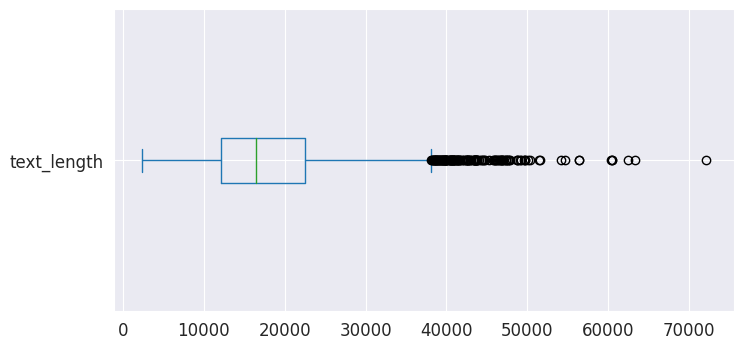

In [ ]:
df["text_length"].plot(kind="box", vert=False);

- 50% percent of the speeches (the box in the middle) have a length between roughly 12,000 and 22,000 characters, and the median is at about 16,000
- The distribution is obviously left-skewed with a long tail and many outliers to the right.
- We can get some more details by plotting a histogram:

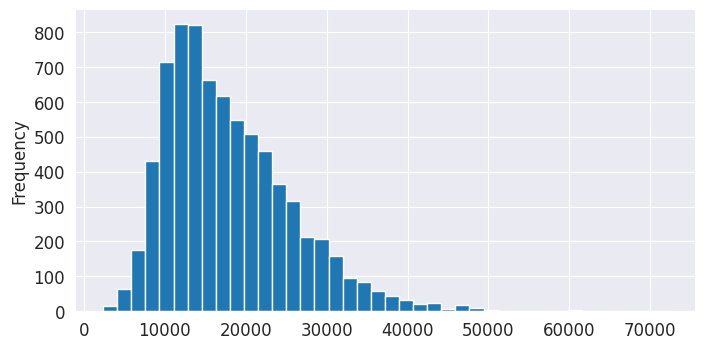

In [ ]:
df["text_length"].plot(kind="hist", bins=40);

- Peculiarities in the data often become visible when different subsets of the data are examined.

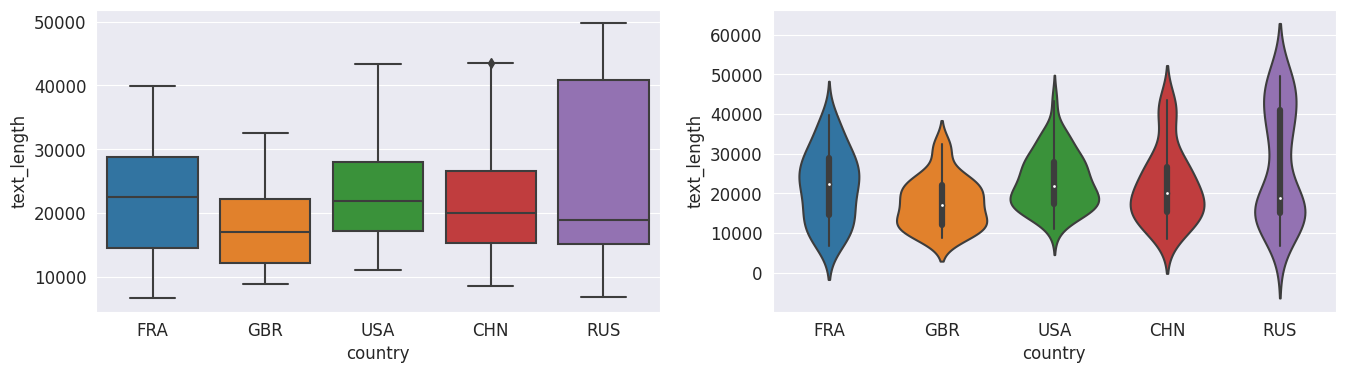

In [ ]:
condition = df['country'].isin(['USA', 'FRA', 'GBR', 'CHN', 'RUS'])

fig, ax = plt.subplots(1, 2, figsize=(16,4))
sns.boxplot(data=df[condition], x="country", y="text_length", ax=ax[0])
sns.violinplot(data=df[condition], x="country", y="text_length", ax=ax[1])
plt.show()

- Both plots reveal that the dispersion of values, in this case the lengths of the speeches, for Russia is much larger than for Great Britain. 
- But the existence of multiple peaks, as in Russia, only becomes apparent in the violin plot.
---
 - If your data contains date or time attributes, it is always interesting to visualize some developments within the data over time.

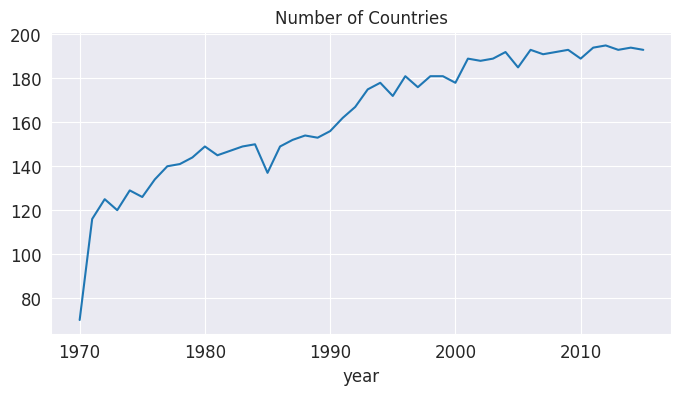

In [ ]:
df.groupby("year").size().plot(title="Number of Countries");

- The timeline reflects the development of the number of countries in the UN, as each country is eligible for only one speech per year. Actually, the UN has 193 members today.

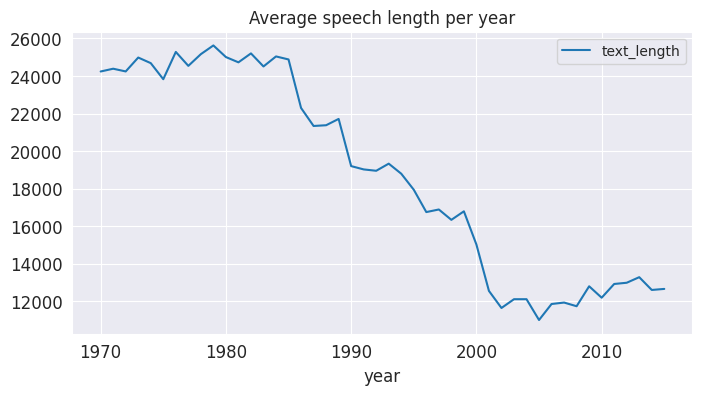

In [ ]:
df[["year", "text_length"]].groupby("year").mean("text_length").plot(title="Average speech length per year");

- Interestingly, the speech length needed to decrease with more countries entering the debates

## Simple Text Preprocessing Pipeline

 - The analysis of metadata such as categories, time, authors, and other
attributes gives some first insights on the corpus. But it’s much more interesting to dig deeper into the actual content and explore frequent words in different subsets or time periods

### Performing Tokenization with Regular Expressions

- Tokenization is the process of extracting words from a sequence of characters.
- In Western languages, words are often separated by whitespaces and punctuation characters.
- The simplest and fastest tokenizer is Python’s native `str.split()` method, which splits on whitespace. A more flexible way is to use regular
expressions.
- The frequently used expression `[A-Za-z]` is not a good option for matching letters because it misses accented letters like ä or â. 
- Much better is the POSIX character class `\p{L}`, which selects all Unicode letters. Note that we need the `regex` library instead of re to work with POSIX character classes.
- The following expression matches tokens
consisting of at least one letter (\p{L}), preceded and followed by an arbitrary sequence of alphanumeric characters (\w includes digits, letters, and underscore) and hyphens (-):


In [ ]:
def tokenize(text):
  return re.findall(r'[\w-]*\p{L}[\w-]*', text)

text = "Let's defeat SARS-CoV-2 together in 2020!"
tokens = tokenize(text)
print(tokens)

['Let', 's', 'defeat', 'SARS-CoV-2', 'together', 'in']


### Treating Stop Words

- The most frequent words in text are common words such as determiners, auxiliary verbs, pronouns, adverbs, and so on. These words are called stop words. 
- Stop words
usually don’t carry much information but hide interesting content because of their high frequencies. Therefore, stop words are often removed before data analysis or model training.
- Common stop word lists are available for many languages and are integrated in almost any NLP library.
- We will work with NLTK’s list of stop words here, but you could use any list of words as a filter.
- In addition to or instead of a fixed list of stop words, it can be helpful to treat every word that appears in more than, say, 80% of the documents as a stop word.
- Another method is to filter words based on the word type (part of speech)

In [ ]:
stopwords = set(nltk.corpus.stopwords.words('english'))

def remove_stop(tokens):
 return [t for t in tokens if t.lower() not in stopwords]

- Often you’ll need to add domain-specific stop words to the predefined list. For example, if you are analyzing emails, the terms dear and regards will probably appear in almost any document.
-  On the other hand, you might want to treat some of the words in the predefined list not as stop words.
- We can add additional stop words and exclude others from the list using two of Python’s set operators, `|` (union/or) and `-` (difference)

In [ ]:
include_stopwords = {'dear', 'regards', 'must', 'would', 'also'}
exclude_stopwords = {'against'}

stopwords |= include_stopwords
stopwords -= exclude_stopwords

- The stop word list from NLTK is conservative and contains only 179 words. Surprisingly, *'would'* is not considered a stop word, while *'wouldn’t'* is.
- Stop word removal is a coarse-grained rule-based method. Be careful with the stop word lists you are using, and make sure that you don’t delete valuable information.
- Look at this simple example: “I don’t like ice cream.”
- Both `NLTK` and `spaCy` have I and don’t (same as do not) in their stop word lists. 
- If you remove those stop words, all that’s left is *'like ice cream'*. This kind of preprocessing would heavily distort any kind of sentiment analysis.
- `TF-IDF` weighting automatically underweighs frequently occurring words but keeps those terms in the vocabulary.

### Processing a Pipeline

- We want to create a new column called tokens containing the lowercased, tokenized text without stop words for each document.

In [ ]:
pipeline = [str.lower, tokenize, remove_stop]

def prepare(text, pipeline):
  for transform in pipeline:
    text = transform(text)
    
  return text

In [ ]:
df["tokens"] = df["text"].apply(prepare, pipeline=pipeline)
df["num_tokens"] = df["tokens"].map(len)

In [ ]:
df.sample(2)

,session,year,country,country_name,speaker,position,text,text_length,tokens,num_tokens
802,31,1976,SUR,Suriname,Mr. Henck A. E. Anon,Prime Minister and Minister for General and Fo...,"Mr. President, it gives me great pleasure to e...",19923,"[mr, president, gives, great, pleasure, extend...",1576
1061,33,1978,PAK,Pakistan,Shahi,NaN,"﻿\tMr. President, the Pakistan delegation cong...",31537,"[mr, president, pakistan, delegation, congratu...",2589


## Word Frequency Analysis

- Frequently used words and phrases can give us some basic understanding of the discussed topics.
- However, word frequency analysis ignores the order and the context of the words.
- This is the idea of the famous bag-of-words model: all the words are thrown into a bag where they tumble into a jumble.
- The original arrangement in the text is lost; only the frequency of the terms is taken into account.
- This model does not work well for complex tasks such as sentiment analysis or question answering, but it works surprisingly well for classification and topic modeling.
- In addition, it’s a good starting point for understanding what the texts are all about.

In [ ]:
from collections import Counter

tokens = tokenize("She likes my cats and my cats like my sofa.")
counter = Counter(tokens)
print(counter)

Counter({'my': 3, 'cats': 2, 'She': 1, 'likes': 1, 'and': 1, 'like': 1, 'sofa': 1})


In [ ]:
more_tokens = tokenize("She likes dogs and cats.")
counter.update(more_tokens)
print(counter)

Counter({'my': 3, 'cats': 3, 'She': 2, 'likes': 2, 'and': 2, 'like': 1, 'sofa': 1, 'dogs': 1})


- To find the most frequent words within a corpus, we need to create a counter from the list of all words in all documents.

In [ ]:
counter = Counter()
df['tokens'].map(counter.update)
print(counter.most_common(5))

[('nations', 124508), ('united', 120763), ('international', 117223), ('world', 89421), ('countries', 85734)]


For further processing and analysis, it is much more convenient to transform the counter into a Pandas `DataFrame`

In [ ]:
def count_words(df, column = 'tokens', preprocess = None, min_freq = 2):
  # process tokens and update counter
  def update(doc):
    tokens = preprocess(doc) if preprocess else doc
    counter.update(tokens)

  # create counter and run through all data
  counter = Counter()
  df[column].map(update)

  # transform counter into a DataFrame
  freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
  freq_df.index.name = 'token'
  freq_df = freq_df[freq_df["freq"] >= min_freq]
  return freq_df.sort_values('freq', ascending=False)

In [ ]:
freq_df = count_words(df)
freq_df.head(5)

,freq
token,
nations,124508
united,120763
international,117223
world,89421
countries,85734


- If we don’t want to use precomputed tokens for some special analysis, we could tokenize the text on the fly with a custom preprocessing function as the third parameter. For example, we could generate and count all words with 10 or more characters with this on-the-fly tokenization of the text:

In [ ]:
count_words(df, 
            column='text',
            preprocess=lambda text: re.findall(r"\w{10,}", text)).head(5)

,freq
token,
international,106974
development,51334
Government,35528
Organization,33763
developing,25177


### Frequency Diagram

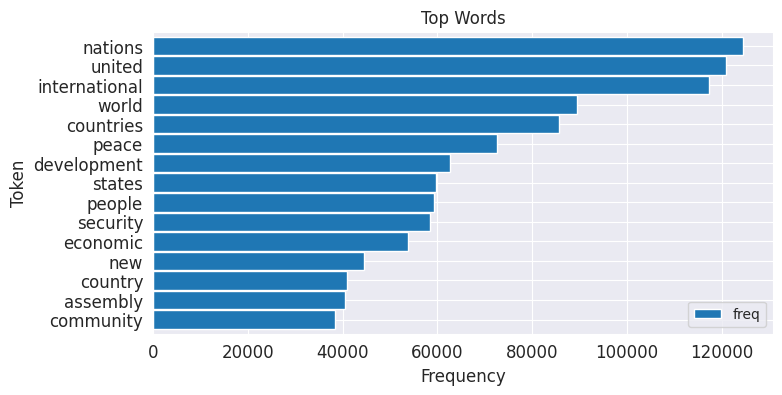

In [ ]:
ax = freq_df.head(15).plot(kind='barh', width=0.95)
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')
plt.show()

### Word Clouds

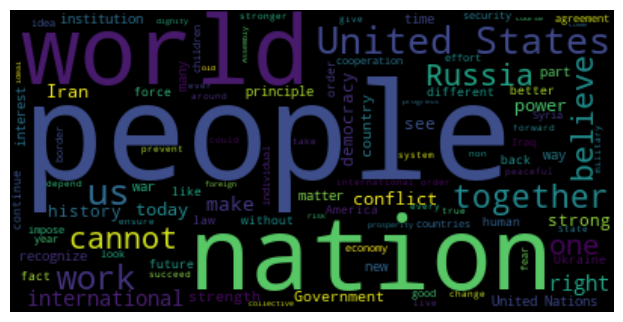

In [ ]:
from wordcloud import WordCloud

wc = WordCloud(max_words=100, stopwords=stopwords)

data = df[(df["year"] == 2015) & (df["country"] == "USA")]["text"].values[0]
wc.generate(data)
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

- This works only for a single text and not a (potentially large) set of documents.
- For the latter use case, it is much faster to create a frequency counter first and then use the function `generate_from_frequencies()`.
- Our blueprint is a little wrapper around this function to also support a Pandas Series containing frequency values as created by count_words.
- The `wordcloud` module ignores the stop word list if `generate_from_frequencies` is called. Therefore, we apply an extra filter.

In [ ]:
def wordcloud(word_freq, title=None, max_words=200, stopwords=None):
  wc = WordCloud(width=800, height=400,
  background_color= "black", colormap="Paired",
  max_font_size=150, max_words=max_words)

  # convert DataFrame into dict
  if type(word_freq) == pd.Series:
    counter = Counter(word_freq.fillna(0).to_dict())
  else:
    counter = word_freq
  # filter stop words in frequency counter
  if stopwords is not None:
    counter = {token:freq for (token, freq) in counter.items()
               if token not in stopwords}

  wc.generate_from_frequencies(counter)
  plt.title(title)
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")

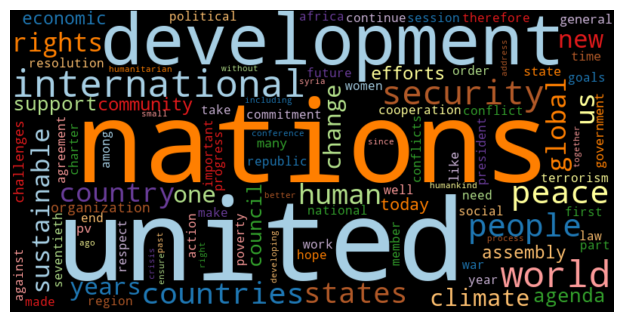

In [ ]:
# Word clouds for the 2015 speeches including all words
freq_2015_df = count_words(df[df['year']==2015])
plt.figure()
wordcloud(freq_2015_df['freq'], max_words=100)

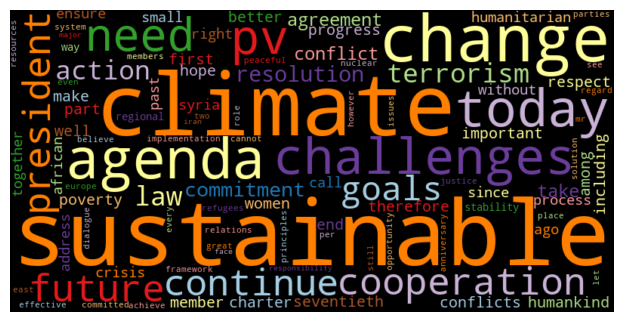

In [ ]:
# without the 50 most frequent words
wordcloud(freq_2015_df['freq'], max_words=100, stopwords=freq_df.head(50).index)

- The later word cloud without the most frequent words of the corpus gives a much better idea of the 2015 topics, but there are still frequent and unspecific words like *'today'* or *'challenges'*. 

### Ranking with TF-IDF

- As illustrated in the previous section, visualizing the most frequent words usually does not reveal much insight.
- Even if stop words are removed, the most common words are usually obvious domain-specific terms that are quite similar in any subset (slice) of the data.
- We want to highlight words whose actual word frequency in a slice is higher than their total probability would suggest.
- There is a number of algorithms to measure the *“surprise”* factor of a word. One of the simplest but best working approaches is to complement the term frequency with the inverse document frequency (TF-IDF)

#### Inverse Document Frequency
- The inverse document frequency (IDF) is a weighting factor that measures the *“unusualness”* of a term in a corpus. It is often used to reduce the influence of common terms for data analysis or machine learning.
- Given a corpus (set of documents) $C$, the *document frequency* $df(t)$ is simply the number of documents $d$ in $C$ that contain the term $t$:
$$
df(t) = \|(d ∈ C| t ∈ d)\|
$$
- Terms appearing in many documents have a high document frequency. Based on this, we can define the *inverse document frequency* $idf(t)$ as follows:
$$
idf(t) = log\left(\frac{|C|}{df(t)}\right)
$$
- The logarithm is used for sublinear scaling. Otherwise, rare words would get extremely high IDF scores.
- Note that $idf(t) = 0$ for terms that appear in all documents, i.e., $df(t) = C$ . To not completely ignore those terms, some libraries add a constant to the whole term.
- For the weighting of a term $t$ in a set of documents $D ⊂ C$, we compute the TF-IDF score as the product of the term frequency $tf(t, D)$ and the $idf$ of term $t$:
$$
tfidf(t, D) = tf(t, D) . idf(t)
$$
- This score yields high values for terms appearing frequently in the selected document(s) $D$ but rarely in the other documents of the corpus.

In [ ]:
def compute_idf(df, column = 'tokens', preprocess = None, min_df = 2):
  # process tokens and update counter
  def update(doc):
    tokens = preprocess(doc) if preprocess else doc
    counter.update(set(tokens)) # each token is counter once

  # create counter and run through all data
  counter = Counter()
  df[column].map(update)

  # transform counter into a DataFrame
  idf_df = pd.DataFrame.from_dict(counter, orient='index', columns=['df'])
  idf_df.index.name = 'token'
  idf_df = idf_df[idf_df["df"] >= min_df]
  idf_df["idf"] = np.log(len(df) / idf_df["df"]) + 0.1 # 0.1 is added to account for word that appear in all documents.
  return idf_df

In [ ]:
idf_df = compute_idf(df)
freq_df["tfidf"] = freq_df["freq"] * idf_df["idf"]

In [ ]:
freq_df.head(5)

,freq,tfidf,idf
token,,,
nations,124508,12649.986284,0.101600
united,120763,12285.608632,0.101733
international,117223,12364.276226,0.105477
world,89421,9503.708982,0.106281
countries,85734,10888.485986,0.127003


- Let’s compare the word clouds based on word counts (term frequencies) alone andbTF-IDF scores for the speeches of the first and last years in the corpus. 
- We remove some more stop words that stand for the numbers of the respective debate sessions.

In [ ]:
# TF
freq_1970 = count_words(df[df['year'] == 1970])
freq_2015 = count_words(df[df['year'] == 2015])

# TF-IDF
freq_1970['tfidf'] = freq_1970['freq'] * idf_df['idf']
freq_2015['tfidf'] = freq_2015['freq'] * idf_df['idf']

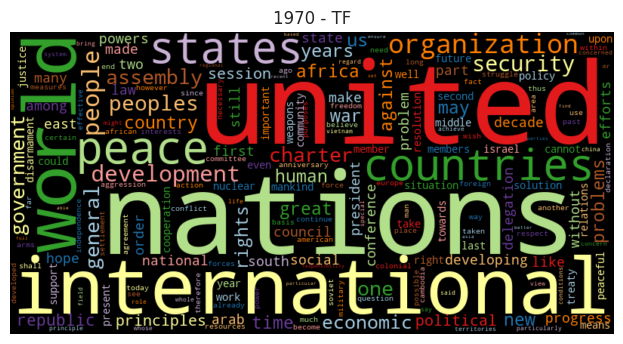

In [ ]:
wordcloud(freq_1970['freq'], 
          title='1970 - TF',
          stopwords=['twenty-fifth', 'twenty-five'])

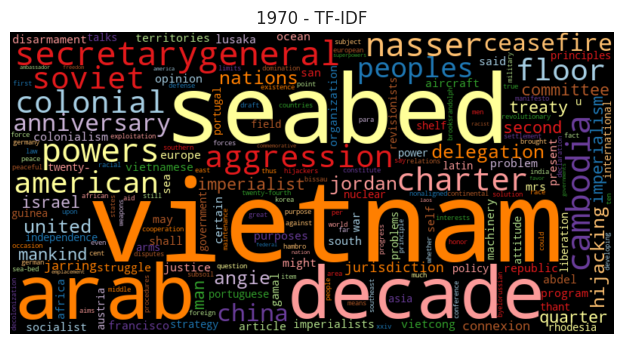

In [ ]:
wordcloud(freq_1970['tfidf'], 
          title='1970 - TF-IDF',
          stopwords=['twenty-fifth', 'twenty-five', 'twenty', 'fifth'])

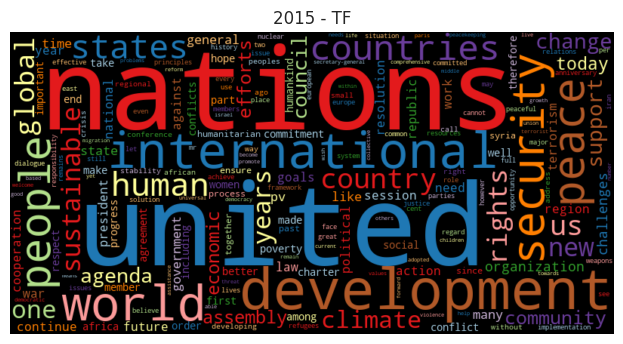

In [ ]:
wordcloud(freq_2015['freq'], 
          title='2015 - TF',
          stopwords=['seventieth'])

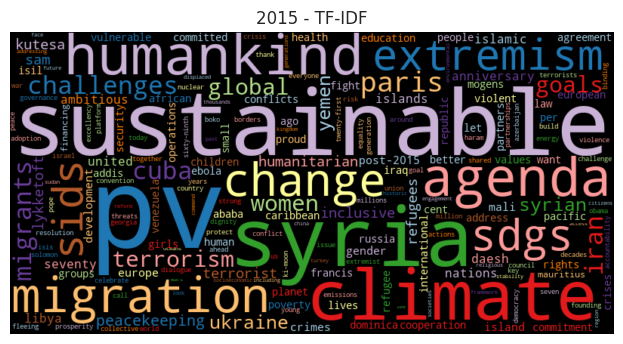

In [ ]:
wordcloud(freq_2015['tfidf'], 
          title='2015 - TF-IDF',
          stopwords=['seventieth'])

- The word clouds impressively demonstrate the power of TF-IDF weighting.
- While the most common words are almost identical in 1970 and 2015, the
TF-IDF weighted visualizations emphasize the differences of political topics.

- Why did we implemented functions to count
words and compute IDF values ourselves instead of using the classes `CountVectorizer` and `TfidfVectorizer` of `scikit-learn`?
- First, the vectorizers produce a vector with weighted term frequencies for each single document instead of arbitrary subsets of the dataset.
- Second, the results are matrices (good for machine learning) and not dataframes (good for slicing, aggregation, and visualization). 

### Finding a Keyword-in-Context

- Word clouds and frequency diagrams are great tools to visually summarize textual data. However, they also often raise questions about why a certain term appears so prominently.
- For example, the 2015 TF-IDF word cloud discussed earlier shows the terms pv, sdgs, or sids, and you probably do not know their meaning.
- To find that out, we need a way to inspect the actual occurrences of
those words in the original, unprepared text.
-  A simple yet clever way to do such an inspection is the keyword-in-context (KWIC) analysis. It produces a list of text fragments of equal length showing the left and right context of a keyword.
- KWIC analysis is implemented in `NLTK` and `textacy`. We will use `textacy`'s `KWIC` function because it is fast and works on the untokenized text. Thus, we can search for strings spanning multiple tokens like *“climate change,”* while `NLTK` cannot.

In [ ]:
from textacy.extract.kwic import keyword_in_context
import random

def kwic(doc_series, keyword, window=35, print_samples=5):
  def add_kwic(text):
    kwic_list.extend(keyword_in_context(text, keyword, ignore_case=True,
                                        window_width=window))
    
  kwic_list = []
  doc_series.map(add_kwic)

  if not print_samples :
    return kwic_list

  k = min(print_samples, len(kwic_list))
  print(f"{k} random samples out of {len(kwic_list)} contexts for '{keyword}':")
  for left, keyword, right in random.sample(list(kwic_list), k):
    print("\t-",re.sub(r'[\n\t]', ' ', left), keyword, re.sub(r'[\n\t]', ' ', right))

In [ ]:
kwic(df[df['year'] == 2015]['text'], 'sdgs', print_samples=5)

5 random samples out of 73 contexts for 'sdgs':
	- the Sustainable Development Goals ( SDGs ), I quoted that portion of the Bib
	-  assistance-delivery to target the  SDGs , then my nation too can climb the 
	-  proposed remedies. Above all, the  SDGs  proclaim in bold letters the conce
	- elated Goals and targets under the  SDGs . In 2009, Solomon Islands, as an a
	- f the word “transformation” in the  SDGs  is most revealing. That is what we


- Obviously, *'sdgs'* is the lowercased version of *'SDGs'*, which stands for *“sustainable development goals.”* With the same analysis we can learn that *'sids'* stands for *“small island developing states.”*
- Always look into the details when you encounter tokens that you do not know or that do not make sense to you! Often they carry important information (like *'sdgs'*) that you as an analyst should be able to interpret. But you’ll also often find artifacts like *'pv'*. Those should be discarded if irrelevant or treated correctly.

### Analyzing N-Grams

- Just knowing that 'climate' is a frequent word does not tell us too much about the topic of discussion because, for example, *'climate change'* and *'political climate'* have completely different meanings. Even *'change climate'* is not the same as *'climate change'*.
- It can therefore be helpful to extend frequency analyses from single words to short sequences of two or three words.
- Basically, we are looking for two types of word sequences: *compounds* and *collocations*.
- A *compound* is a combination of two or more words with a specific meaning. In English, we find compounds in closed form, like *'earthquake'*; hyphenated form like *'self-confident'*; and open form like *'climate change'*. Thus, we may have to consider two tokens as a single semantic unit.
- *Collocations*, in contrast, are words that are frequently used together. Often, they consist of an adjective or verb and a noun, like *'red carpet'* or *'united nations'*.
- In text processing, we usually work with bigrams (sequences of length 2), sometimes even trigrams (length 3).
- The
reason to stick to $n ≤ 3$ is that the number of different n-grams increases exponentially with respect to n, while their frequencies decrease in the same way. By far the most trigrams appear only once in a corpus.

In [ ]:
def ngrams(tokens, n = 2, sep = ' '):
  return [sep.join(ngram) for ngram in zip(*(tokens[i:] for i in range(n)))]

In [ ]:
text = "the visible manifestation of the global climate change"
tokens = tokenize(text)
print(ngrams(tokens, 2))

['the visible', 'visible manifestation', 'manifestation of', 'of the', 'the global', 'global climate', 'climate change']


- As you can see, most of the bigrams contain stop words like prepositions and determiners. Thus, it is advisable to build bigrams without stop words.
- But we need to be careful: if we remove the stop words first and then build the bigrams, we generate bigrams that don’t exist in the original text as a “manifestation global” in the example.
- Thus, we create the bigrams on all tokens but keep only those that do not contain any stop words with this modified `ngrams` function:

In [ ]:
def ngrams(tokens, n = 2, sep = ' ', stopwords = set()):
  return [sep.join(ngram) for ngram in zip(*(tokens[i:] for i in range(n))) if all(t not in stopwords for t in ngram)]

In [ ]:
print(ngrams(tokens, 3))
print(ngrams(tokens, 3, stopwords=stopwords))

['the visible manifestation', 'visible manifestation of', 'manifestation of the', 'of the global', 'the global climate', 'global climate change']
['global climate change']


- Using this `ngrams` function, we can add a column containing all bigrams to our Data Frame and apply the word count to determine the top five bigrams.

In [ ]:
df['bigrams'] = (df['text'].apply(prepare, pipeline=[str.lower, tokenize])
                           .apply(ngrams, n=2, stopwords=stopwords))

count_words(df, 'bigrams').head(5)

,freq
token,
united nations,103236
international community,27786
general assembly,27096
security council,20961
human rights,19856


- Notice that we ignored sentence boundaries during tokenization.
Thus, we will generate nonsense bigrams with the last word of one sentence and the first word of the next.
- Those bigrams will not be very frequent, so they don’t really matter for data exploration.
- If we wanted to prevent this, we would need to identify sentence boundaries, which is much more complicated than word tokenization and not worth the effort here.
- Let’s extend our TF-IDF-based unigram analysis from the previous section and include bigrams.

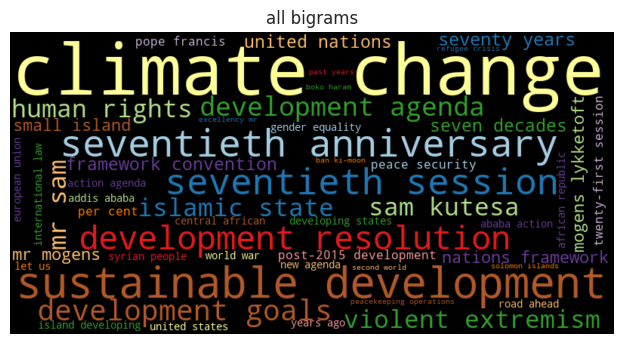

In [ ]:
# concatenate existing IDF DataFrame with bigram IDFs
idf_df = pd.concat([idf_df, compute_idf(df, 'bigrams', min_df=10)])

freq_df = count_words(df[df['year'] == 2015], 'bigrams')
freq_df['tfidf'] = freq_df['freq'] * idf_df['idf']

wordcloud(freq_df['tfidf'], title='all bigrams', max_words=50)

- As we can see in the word cloud, climate change was a frequent bigram in 2015. But to understand the different contexts of climate, it may be interesting to take a look at the bigrams containing climate only.

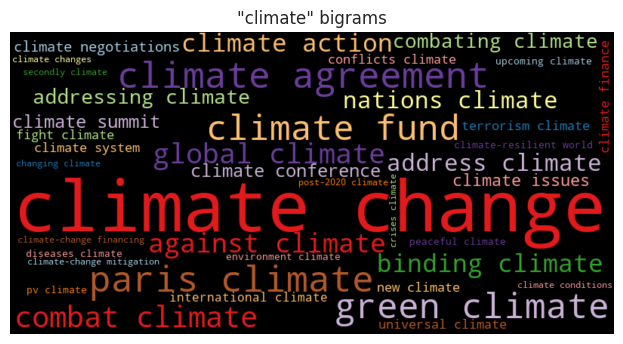

In [ ]:
condition = freq_df.index.str.contains('climate')
wordcloud(freq_df[condition]['freq'], title='"climate" bigrams', max_words=50)

- The approach presented here creates and weights all n-grams that do not contain stopwords. For a first analysis, the results look quite good.
- More sophisticated but also computationally expensive algorithms to identify *collocations* are available, for example, in NLTK’s *collocation finder*.

### : Comparing Frequencies Across Time Intervals and Categories

- We want to track the development of certain keywords over the course of the years in our UN Debates dataset to get an idea about the growing or shrinking importance of topics such as climate change, terrorism, or migration.

In [ ]:
def count_keywords(tokens, keywords):
  counter = Counter((t for t in tokens if t in keywords))
  return [counter[k] for k in keywords]

In [ ]:
keywords = ['nuclear', 'terrorism', 'climate', 'freedom']
tokens = ['nuclear', 'climate', 'climate', 'freedom', 'climate', 'freedom']
print(count_keywords(tokens, keywords))

[1, 0, 3, 2]


- As we can see, the function returns a list of word counts. In fact, it’s a very simple count-vectorizer for keywords.
- If we apply this function to each document in our DataFrame, we get a matrix of counts. The blueprint function `count_keywords_by` does exactly this as a first step. The matrix is then again converted into a `DataFrame` that is finally aggregated and sorted by the supplied grouping
column.
- Even though we use only the attribute year as a grouping criterion
in our examples, the blueprint function allows you to compare word frequencies across any discrete attribute, e.g., country, category, author—you name it. In fact, you could even specify a list of grouping attributes to compute, for example, counts per country and year.


In [ ]:
def count_keywords_by(df, by, keywords, column='tokens'):
  freq_matrix = df[column].apply(count_keywords, keywords=keywords)
  freq_df = pd.DataFrame.from_records(freq_matrix, columns=keywords)
  freq_df[by] = df[by] # copy the grouping column(s)
  
  return freq_df.groupby(by=by).sum().sort_values(by)

In [ ]:
freq_df = count_keywords_by(df, by='year', keywords=keywords)
freq_df.sample(10)

,nuclear,terrorism,climate,freedom
year,,,,
2005,262,609,86,179
1986,807,356,103,270
1972,393,379,74,280
2011,227,257,510,283
1984,890,113,115,314
1971,275,9,35,205
1985,809,144,104,301
2009,431,197,861,100
2000,268,127,61,107


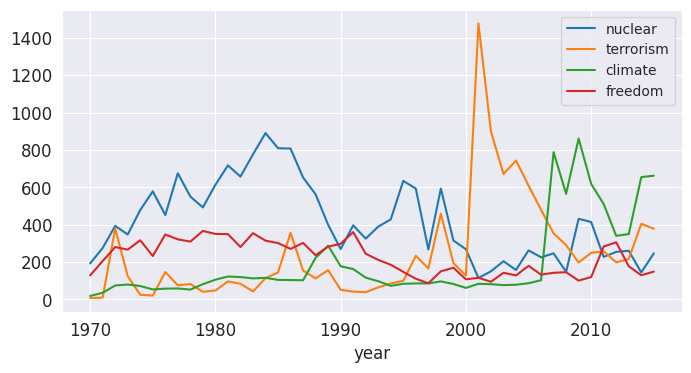

In [ ]:
freq_df.plot(kind='line');

- Note the peak of *'nuclear'* in the 1980s indicating the arms race and the high peak of *'terrorism'* in 2001.
-  It is somehow remarkable that the topic *'climate'* already got some
attention in the 1970s and 1980s. Has it really? Well, if you check with a KWIC analysis, you’d find out that the word *'climate'* in those decades was almost exclusively used in a figurative sense.

### Creating Frequency Heatmaps

- Say we want to analyze the historic developments of global crises like the cold war, terrorism, and climate change. 
- We could pick a selection of significant words and vis‐
ualize their timelines by line charts as in the previous example. But line charts become confusing if you have more than four or five lines.
- An alternative visualization without that limitation is a heatmap, as provided by the Seaborn library.

In [ ]:
keywords = ['terrorism', 'terrorist', 'nuclear', 'war', 'oil',
            'syria', 'syrian', 'refugees', 'migration', 'peacekeeping',
            'humanitarian', 'climate', 'change', 'sustainable', 'sdgs']

freq_df = count_keywords_by(df, by='year', keywords=keywords)

In [ ]:
# compute relative frequencies based on total number of tokens per year
freq_df = freq_df.div(df.groupby('year')['num_tokens'].sum(), axis=0)

# apply square root as sublinear filter for better contrast
freq_df = freq_df.apply(np.sqrt)

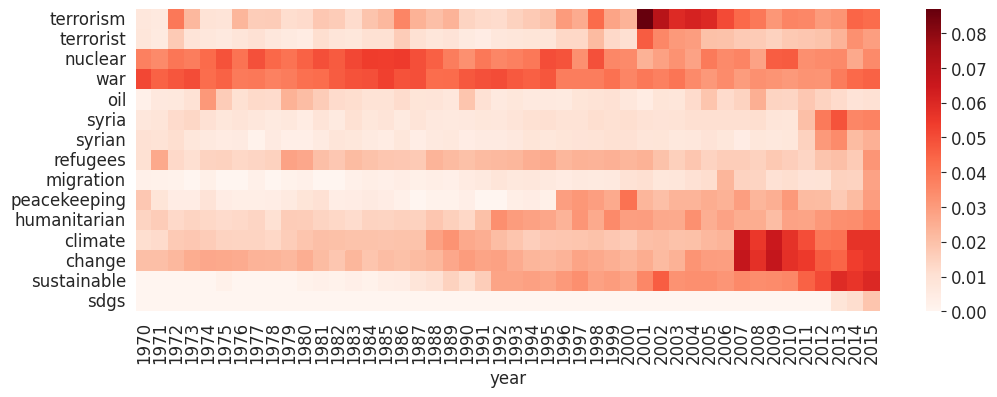

In [ ]:
fig, ax = plt.subplots(figsize = (12,4))
sns.heatmap(data=freq_df.T,
            xticklabels=True, 
            yticklabels=True, 
            cbar=True,
            cmap="Reds");

- There are a few things to consider for this kind of analysis:
  1. Prefer relative frequencies for any kind of comparison.
    Absolute term frequencies are problematic if the total number of tokens per year or category is not stable. For example, absolute frequencies naturally go up if more countries are speaking year after year in our example.
  2. Be careful with the interpretation of frequency diagrams based on keyword lists.
    Although the chart looks like a distribution of topics, it is not! There may be other words representing the same topic but not included in the list. Keywords may also have different meanings (e.g., “climate of the discussion”). Advanced techniques such as topic modeling and word embeddings can help here.
  3. Use sublinear scaling.
    As the frequency values differ greatly, it may be hard to see any change for lessfrequent tokens. Therefore, you should scale the frequencies sublinearly (we applied the square root `np.sqrt`). The visual effect is similar to lowering contrast.

## Closing Remarks

- Data exploration should not only provide initial insights but actually help to develop confidence in your data.
- One thing you should keep in mind is that you should always identify the root cause for any strange tokens popping up. The KWIC analysis is a good tool to search for such tokens.
- There are many aspects of textual analysis that we did not cover:
  - Author-related information can help to identify influential writers, if that is one of your project goals. Authors can be distinguished by activity, social scores, writing style, etc.
  - Sometimes it is interesting to compare authors or different corpora on the same topic by their readability. The `textacy` library has a function called `textstats` that computes different readability scores and other statistics in a single pass over the text.
  - An interesting tool to identify and visualize distinguishing terms between categories (e.g., political parties) is Jason Kessler’s `Scattertext` library
  - Besides plain Python, you can also use interactive visual tools for data analysis. Microsoft’s PowerBI has a nice word cloud add-on and lots of other options to produce interactive charts. We mention it because it is free to use in the desktop version and supports Python and R for data preparation and visualization.
  - For larger projects, we recommend setting up a search engine like `Apache SOLR`, `Elasticsearch`, or `Tantivy`. Those platforms create specialized indexes (also using TF-IDF weighting) for fast full-text search. Python APIs are available for all of them.



